<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN1_from_Heiselberg_2020_training_iceberg_ship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import all required libraries

In [1]:
# Libraries to access files from my drive
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam

Then, import data from Google Drive. Code adapted from [here](https://www.roelpeters.be/how-to-uploading-files-in-google-colab/).

In [2]:
# Authenticate with Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def read_json_from_drive(file_id, file_name):
    dl = drive.CreateFile({'id': file_id})
    dl.GetContentFile(file_name)
    return pd.read_json(file_name)

df_train = read_json_from_drive('1WlrJpjbaMXEB5SrrlweDhXngBOJZHtyo', 'train.json')
print(df_train.head())

         id  ... is_iceberg
0  dfd5f913  ...          0
1  e25388fd  ...          0
2  58b2aaa0  ...          1
3  4cfc3a18  ...          0
4  271f93f4  ...          0

[5 rows x 5 columns]


Prepare the data

In [19]:
df_train["inc_angle"] = df_train["inc_angle"].replace(["na"], np.nan)

# Get the labels (y-values)
labels = np.array(df_train["is_iceberg"])

# Create empty list for the images
imgs = []
for i, row in df_train.iterrows():
    # Reshape list to image
    hh  = np.reshape(row["band_1"], (75, 75))
    hv  = np.reshape(row["band_2"], (75, 75))
    b3  = hh + hv
    
    # Rescale images between 0 and 1 for faster convergence rate
    hh = (hh - hh.min())/(hh.max()-hh.min())
    
    hv = (hv - hv.min())/(hv.max()-hv.min())
    b3 = (b3 - b3.min())/(b3.max()-b3.min())

    # Stack the bands and append them to imgs
    imgs.append(np.dstack((hh, hv, b3)))

# Split dataset into training and test data
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.25, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)

Set up DataGenerators

In [20]:
training_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')#,
    #validation_split = 0.2)

train_generator = training_datagen.flow(x_train, y_train)#,
                                     #batch_size=64)#, 
                                     #subset = "training")

val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow(x_test, y_test)#,
                                     #batch_size=16)#, 
                                     #subset = "training")




Set up and compile model

In [24]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 75x75 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 75, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 means ship and 1 means iceberg
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, decay=0.0),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)      

Train model

In [25]:
history = model.fit(
      train_generator,
      #steps_per_epoch=10,  
      epochs=100,
      verbose=1,
      validation_data = val_generator)#,
      #validation_steps=10)

Epoch 1/200
38/38 [==============================] - 3s 60ms/step - loss: 0.7276 - accuracy: 0.4955 - val_loss: 0.7040 - val_accuracy: 0.5237
Epoch 2/200
38/38 [==============================] - 2s 56ms/step - loss: 0.7971 - accuracy: 0.5094 - val_loss: 0.7436 - val_accuracy: 0.4888
Epoch 3/200
38/38 [==============================] - 2s 57ms/step - loss: 0.7728 - accuracy: 0.5138 - val_loss: 0.6155 - val_accuracy: 0.7107
Epoch 4/200
38/38 [==============================] - 2s 57ms/step - loss: 0.6774 - accuracy: 0.6112 - val_loss: 1.0536 - val_accuracy: 0.4988
Epoch 5/200
38/38 [==============================] - 2s 58ms/step - loss: 0.8445 - accuracy: 0.5797 - val_loss: 0.5752 - val_accuracy: 0.7332
Epoch 6/200
38/38 [==============================] - 2s 58ms/step - loss: 0.7265 - accuracy: 0.6486 - val_loss: 0.5651 - val_accuracy: 0.7382
Epoch 7/200
38/38 [==============================] - 2s 58ms/step - loss: 0.6696 - accuracy: 0.6153 - val_loss: 0.5341 - val_accuracy: 0.7382
Epoch 

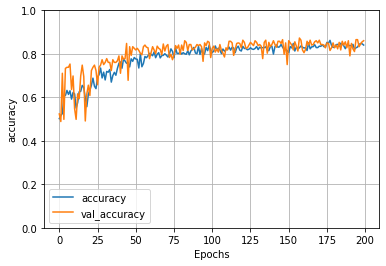

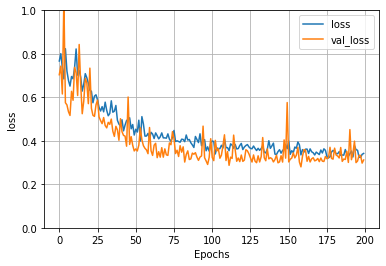

In [26]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")